# Next Step

1. Tthe prediction model
2. Remove outliers?, log_transform costs?
3. Integrate this into the existing PTO pipeline.
4. A simple maximizing linear utility with SPO


---

# TODO
Use LR, or this simple NN.

In [48]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')

import warnings
warnings.filterwarnings("ignore")

from myutil import *
from features import *

In [49]:
df = pd.read_csv('data/data.csv')

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

In [50]:
all_features = df[get_all_features(df)]
risk_score = df['risk_score_t']
g_factor = df['g_continuous']
decision = df['propensity_score']

feats = all_features.values
risk = risk_score.values
cost = np.ones(risk.shape)
gainF = g_factor.values
decision = decision.values

alpha = 0.5
Q = 1e3

data = feats, risk, cost, gainF, decision

num_data, num_items = risk.shape[0], 1

print(num_data, num_items)

48784 1


In [51]:
utility = risk * gainF * decision
utility

array([3.05231995, 3.50684358, 3.74671202, ..., 3.067156  , 4.54563509,
       2.65429509])

In [52]:
# d = cp.Variable(decision.shape, nonneg=True)
# if alpha != 1:
#     objective = cp.Maximize(cp.sum(cp.multiply(cp.multiply(gainF, risk), d)) ** (1 - alpha) / (1 - alpha))
# else:
#     objective = cp.Maximize(cp.sum(cp.log(cp.multiply(cp.multiply(gainF, risk), d))))

# constraints = [d >= 0, cp.sum(cost * d) <= Q, d <= 1]

# problem = cp.Problem(objective, constraints)
# problem.solve(solver=cp.SCS, max_iters=4000,verbose=False)

# optimal_decision = d.value
# print("Optimal Decision:", optimal_decision)
# print("Optimal Objective Value:", problem.value)

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class RiskDataset(Dataset):
    def __init__(self, features, risks):
        self.features = torch.FloatTensor(features)
        self.risks = torch.FloatTensor(risks).reshape(-1, 1)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return self.features[idx], self.risks[idx]
    
class RiskPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.ReLU()  # Ensure the output is non-negative
        )
    
    def forward(self, x):
        return self.model(x)

# Training function
def train_model(features, risks, epochs=1, batch_size=32):
    dataset = RiskDataset(features, risks)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = RiskPredictor(features.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        for batch_features, batch_risks in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_features)
            loss = criterion(predictions, batch_risks)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return model


model = train_model(feats, risk)

def AlphaFairness(util,alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha)/(1-alpha))

In [75]:
def solve_optimization(gainF, risk, cost, alpha, Q):
    # Flatten input arrays
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)
    
    utils = cp.multiply(cp.multiply(gainF, risk), d)
    
    if alpha == 'inf':
        # Maximin formulation
        t = cp.Variable()  # auxiliary variable for minimum utility
        objective = cp.Maximize(t)
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q,
            utils >= t  # t is the minimum utility
        ]
    elif alpha == 1:
        # Nash welfare (alpha = 1)
        objective = cp.Maximize(cp.sum(cp.log(utils)))
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q
        ]
    else:
        # General alpha-fairness
        objective = cp.Maximize(cp.sum(utils**(1-alpha))/(1-alpha) if alpha != 0 
                              else cp.sum(utils))
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q
        ]
    
    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, max_iters=2000, verbose=False)
    
    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")
    
    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)
    
    return optimal_decision, optimal_value

In [76]:
loss = 0
optsum = 0

# predict the risk
model.eval()
predicted_risk = model(torch.FloatTensor(feats)).detach().numpy()

predicted_risk.flatten()

array([0.        , 0.        , 0.42218953, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [77]:
risk.flatten()

array([ 1.98742993,  7.67793443,  0.40767793, ...,  1.35892645,
       10.99031765,  1.68167148])

In [78]:
print("decision shape:", decision.shape)
print("gainF shape:", gainF.shape)
print("risk shape:", risk.shape)

decision shape: (48784,)
gainF shape: (48784,)
risk shape: (48784,)


In [79]:

# pred_sol,_ = solve_optimization(gainF, predicted_risk, cost, alpha='inf', Q=Q)

In [80]:
# pred_obj = np.sum((risk * gainF * pred_sol)**(1-alpha)/(1-alpha))

In [81]:
# true_obj = np.sum((optimal_decision * gainF * risk)**(1-alpha)/(1-alpha))

Alpha: 0, Regret: -169101.7303, True Objective: 7136.4680, Predicted Objective: 176238.1984
Alpha: 0.5, Regret: 4273.5029, True Objective: 37238.0095, Predicted Objective: 32964.5066
Alpha: 1, Regret: nan, True Objective: -inf, Predicted Objective: -inf
Alpha: inf, Regret: 0.0000, True Objective: 0.0000, Predicted Objective: 0.0000


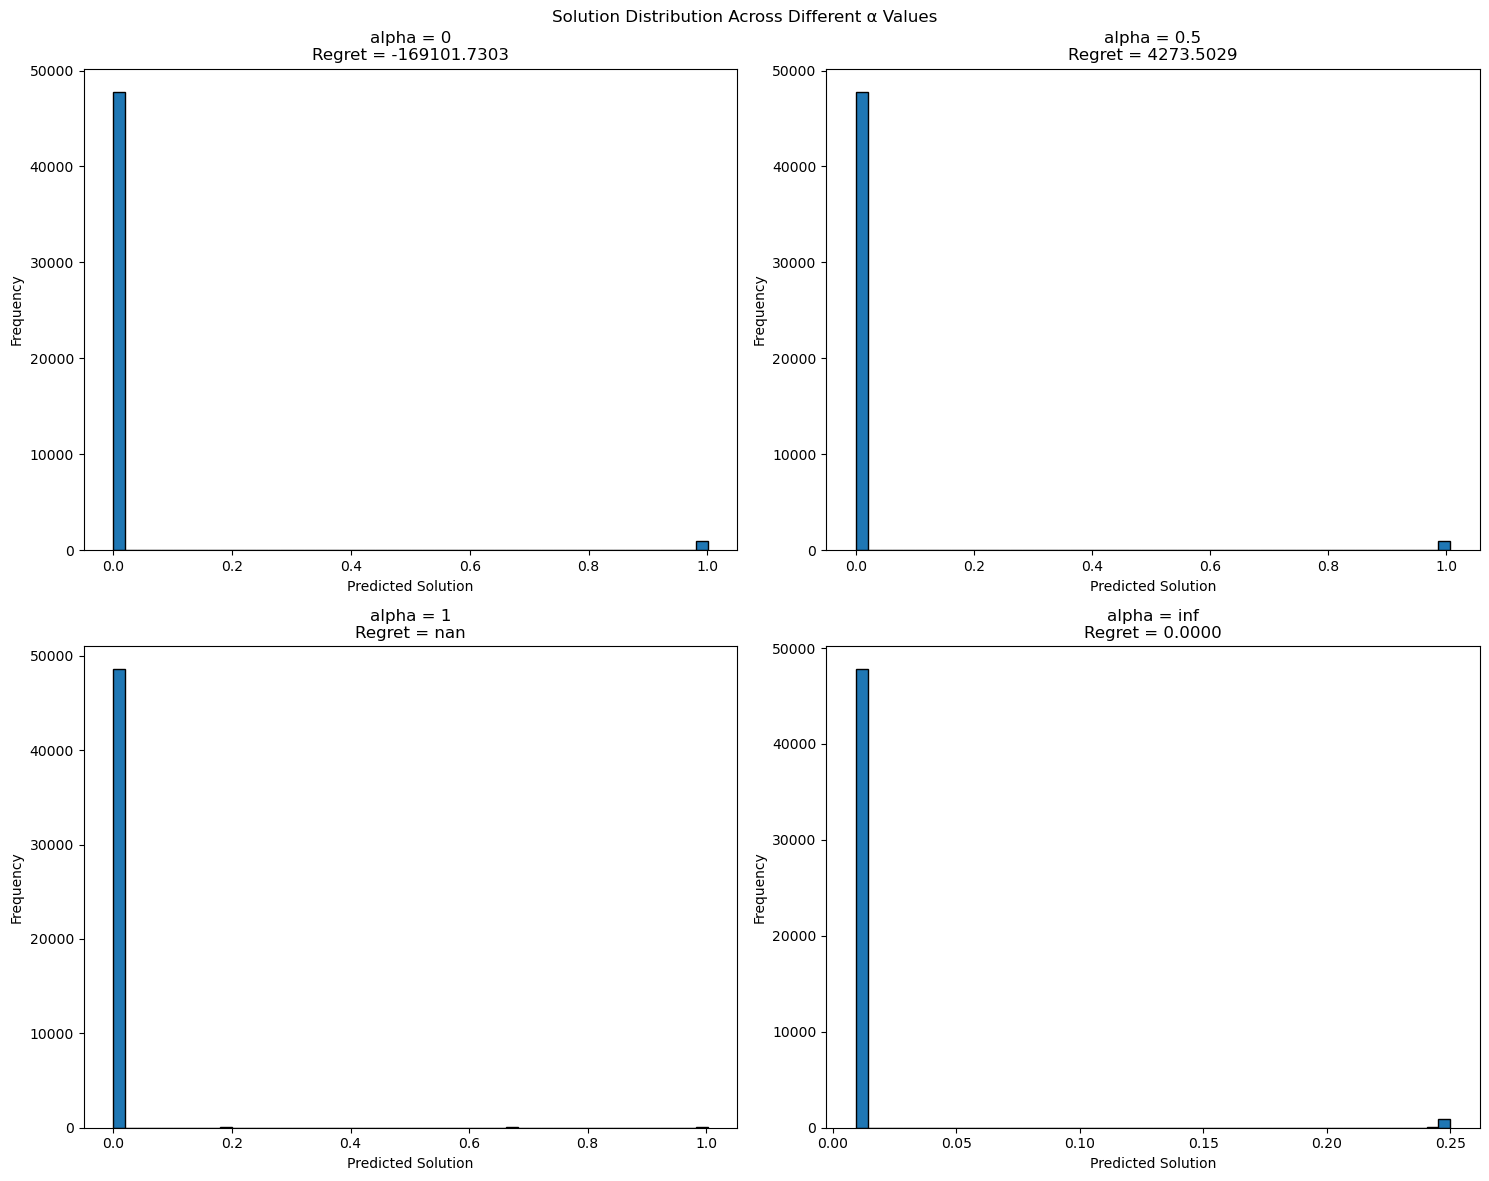

In [82]:
def analyze_alpha_fairness(model, feats, gainF, risk, cost, Q):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Solution Distribution Across Different α Values')

    alphas = [0, 0.5, 1, 'inf']
    regrets = []

    model.eval()
    predicted_risk = model(torch.FloatTensor(feats)).detach().numpy()

    opt_sol, opt_val = solve_optimization(gainF, risk, cost, alpha='inf', Q=Q)
    
    for idx, alpha in enumerate(alphas):
        row = idx // 2
        col = idx % 2
        
        pred_sol, _ = solve_optimization(gainF, predicted_risk, cost, alpha, Q)
        
        # Calculate objectives
        if alpha != 'inf':
            if alpha == 1:
                pred_obj = np.sum(np.log(risk * gainF * pred_sol))
                true_obj = np.sum(np.log(risk * gainF * opt_sol))
            else:
                pred_obj = np.sum((risk * gainF * pred_sol)**(1-alpha)/(1-alpha))
                true_obj = np.sum((opt_sol * gainF * risk)**(1-alpha)/(1-alpha))
        else:
            pred_obj = np.min(risk * gainF * pred_sol)
            true_obj = np.min(risk * gainF * opt_sol)
        
        regret = true_obj - pred_obj
        regrets.append((alpha, regret, true_obj, pred_obj))
        
        axes[row, col].hist(pred_sol, bins=50, edgecolor='k')
        axes[row, col].set_xlabel('Predicted Solution')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_title(f'alpha = {alpha}\nRegret = {regret:.4f}')
        
    plt.tight_layout()
    
    for alpha, regret, true_obj, pred_obj in regrets:
        print(f'Alpha: {alpha}, Regret: {regret:.4f}, True Objective: {true_obj:.4f}, Predicted Objective: {pred_obj:.4f}')
    
    return fig, regrets

fig, regrets = analyze_alpha_fairness(model, feats, gainF, risk, cost, Q)
plt.show()

regrets

# SPO

In [84]:
# Why is the predicted objective zero or even more fair?
alpha = 'inf'
regret = 0
model.eval()

predicted_risk = model(torch.FloatTensor(feats)).detach().numpy()
predicted_risk.flatten()
opt_sol, opt_val = solve_optimization(gainF, risk, cost, alpha='inf', Q=Q)

In [85]:
print("Mean:", np.mean(predicted_risk))
print("Standard Deviation:", np.std(predicted_risk))
print("Min:", np.min(predicted_risk))
print("Max:", np.max(predicted_risk))

Mean: 0.00910915
Standard Deviation: 0.06196082
Min: 0.0
Max: 0.8517196


In [86]:
opt_sol, opt_val

(array([0.00806267, 0.03811568, 0.00064303, ..., 0.00399622, 0.03194693,
        0.00774789]),
 0.0)